## Xenon PV curve

https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf

In [87]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-11-05 11:15:01
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from system_of_units import *

In [89]:
from math import pi, sqrt, exp, log

In [90]:
from IPython.display import Image

Reference values

T = 273.15 

P = 0.101 MPa

rho = 5.9 kg/m3

In [288]:
class Xenon:
    def __init__(self):
        np.set_printoptions(precision=3)
        np.set_printoptions(suppress=True)
        f = np.array([
             [0.482, -1.178, -0.240, -0.075, -0.214, -0.007, -3.565],
             [-0.223, 0.611, -0.358, -0.039, 0.853,  0.039,  8.736],
             [0.677, -1.591,  1.385, -0.038, -1.774, -0.110, -11.835],
             [-0.827, 2.188, -2.267,  0.404, 2.118,  0.176,  9.568],
             [0.597, -1.664,  1.891, -0.463, -1.539, -0.158, -4.614],
             [-0.260, 0.741, -0.896,  0.240, 0.693,  0.075,  1.229],
             [0.067, -0.192, 0.244, -0.067, -0.190, -0.015, -0.139],
             [-0.001, 0.023, -0.035,  0.001, 0.029,  0.,     0.],
             [0.    , -0.001, 0.002,  0.   , -0.002, 0.,     0.],
             ])
        self.F   = np.asmatrix(f.transpose())
        self.rho = np.array([0., 2.970,0.405,2.325,1.113,0.611,1.485,1.101])
        self.Q   = np.array([-1., 0.,1.,3.,21.,24.83,250.,21.00])
        self.E   = np.array([1.5, 1.94,1.46,1.02,0.98, 1.173,0,0])
        self.Tr = 289.7 # Ref temperature in Kelvin
        self.Rr = 1000. # Ref density in kg/m3
        self.Rm  = 8.31 # Molar gas constant in J/(mol K)
        self.M  = 131.29 # molar xenon mass in g/mol
        self.R  = 1e+3 * self.Rm / self.M # specific gas constant in J((kg k)) 
        self.T0 = 273.15 # 0 in K
        self.pascal_to_atm = 9.9E-6 
 
        
    def P(self, T, RHO, perfect=False):
        """Computes pressure as a function of density and temperature for xenon
            T in Celsius
            rho in kg/m3
            P in bar
        """
    
        t = (T + self.T0) / self.Tr    # relative temperature
        r = RHO / self.Rr  # relative density 
        
        if perfect == False:
            p = r * (t + self.FF(r, t))  # relative pressure
        else:
            p = r * t
   
        return p * self.R * self.Tr * self.Rr * self.pascal_to_atm

    def psi(self,i, r):
        
        def sumij (r):
            sumj = 0
            for k in range(9):
                j = k + 1
                sumj+= j * self.F[i,k] * r**j
            return sumj
        
        if i < 4 : 
            return sumij(r)
        elif i == 4:
            return sumij(self.rho[2])
        elif i == 5:
            return sumij(self.rho[5])
        else:
            print('Error: i = {} out of bounds'.format(i))
            
   
    def Xi(self,i, t):
        if i < 4 : 
            return t** (-self.Q[i])
        elif i == 4:
            return t** (-self.Q[4])
        #elif i == 5:
            #if self.E[4] < t < self.E[5]:
            #    return self.E[2] * t **(-self.Q[6]) + self.E[3] * t**(-self.Q[7])
            #else:
            #    return 0
        else:
            return 0
        
    def FF(self, r, t):
        f = 0
        for i in range(6):
            f += self.psi(i, r) * self.Xi(i, t) 
        return f

    def __str__(self):
        return '< F = {}\n rho = {}\n Q = {}\n E = {}>'.format(self.F, self.rho, self.Q, self.E)

    __repr__ =     __str__
   
    
    

In [289]:
xe = Xenon()

In [290]:
xe

< F = [[  0.482  -0.223   0.677  -0.827   0.597  -0.26    0.067  -0.001   0.   ]
 [ -1.178   0.611  -1.591   2.188  -1.664   0.741  -0.192   0.023  -0.001]
 [ -0.24   -0.358   1.385  -2.267   1.891  -0.896   0.244  -0.035   0.002]
 [ -0.075  -0.039  -0.038   0.404  -0.463   0.24   -0.067   0.001   0.   ]
 [ -0.214   0.853  -1.774   2.118  -1.539   0.693  -0.19    0.029  -0.002]
 [ -0.007   0.039  -0.11    0.176  -0.158   0.075  -0.015   0.      0.   ]
 [ -3.565   8.736 -11.835   9.568  -4.614   1.229  -0.139   0.      0.   ]]
 rho = [ 0.     2.97   0.405  2.325  1.113  0.611  1.485  1.101]
 Q = [  -1.      0.      1.      3.     21.     24.83  250.     21.  ]
 E = [ 1.5    1.94   1.46   1.02   0.98   1.173  0.     0.   ]>

#### rho = 5.9 kg/m3 is the density at which P = 1 atm and T = 0 C

In [94]:
xe.P(T=0, RHO=5.9, perfect=True) 

1.0098521316551148

In [95]:
xe.P(T=0, RHO=5.9, perfect=False) 

1.002501680455798

In [96]:
xe.P(0, 20*5.9, perfect=True)

20.197042633102292

In [291]:
rho_20 = 23.5*5.9
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 0C'.format(
rho_20, xe.P(0, rho_20, perfect=False), xe.P(0, rho_20, perfect=True)) )

 rho = 138.65 kg/m2 is the density at which P = 20.044967040792258 atm (P_perfect = 23.731525093895193 atm) and T = 0C


In [98]:
rho_2020 = 124
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_2020, xe.P(20, rho_2020, perfect=False), xe.P(0, rho_2020, perfect=True)) )

 rho = 124 kg/m3 is the density at which P = 20.025562486690163 atm (P_perfect = 21.22401090258207 atm) and T = 20C


In [99]:
rho_1520 = 90
print(' rho = {} kg/m2 is the density at which P = {} atm (P_perfect = {} atm) and T = 20C'.format(
rho_1520, xe.P(20, rho_1520, perfect=False), xe.P(0, rho_1520, perfect=True)) )

 rho = 90 kg/m2 is the density at which P = 15.071853690374631 atm (P_perfect = 15.40452404219666 atm) and T = 20C


In [102]:
T = np.arange(-75, 25, 0.5)

In [103]:
PF = [xe.P(t, rho_2020, perfect=False) for t in T]

In [104]:
PT = [xe.P(t, rho_2020, perfect=True) for t in T]

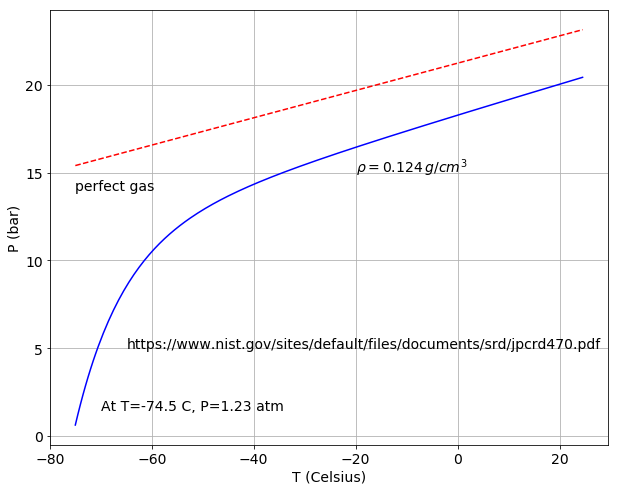

In [105]:
plt.plot(T,PF,'b')
plt.plot(T,PT,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-20, 15, r'$\rho=0.124 \, g/cm^3$')
plt.text(-75, 14, r'perfect gas')
plt.text(-65, 5, r'https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf')
plt.text(-70, 1.5, r'At T=-74.5 C, P=1.23 atm')
plt.show()

In [106]:
T = np.arange(-75.0, -72.5, 0.1)

In [107]:
PF = [xe.P(t, rho_2020, perfect=False) for t in T]
PT = [xe.P(t, rho_2020, perfect=True) for t in T]

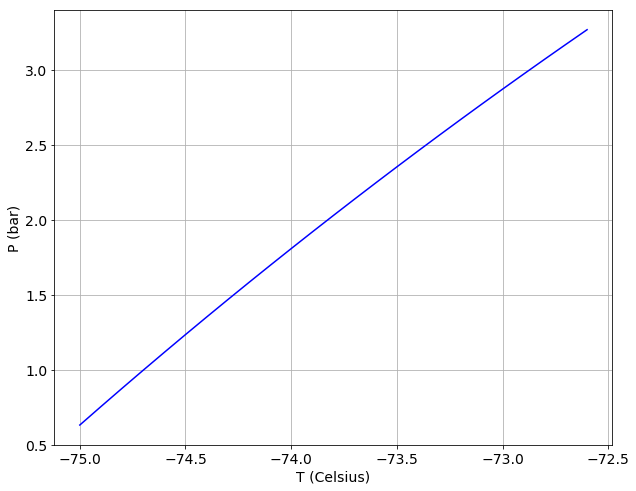

In [108]:
plt.plot(T,PF,'b')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')

In [109]:
T

array([-75. , -74.9, -74.8, -74.7, -74.6, -74.5, -74.4, -74.3, -74.2,
       -74.1, -74. , -73.9, -73.8, -73.7, -73.6, -73.5, -73.4, -73.3,
       -73.2, -73.1, -73. , -72.9, -72.8, -72.7, -72.6])

In [110]:
PF

[0.63342753543520891,
 0.75633550341371902,
 0.87799340663040693,
 0.99841563440355274,
 1.1176164030512865,
 1.2356097580579646,
 1.352409576211784,
 1.4680295677151725,
 1.5824832782671381,
 1.6957840911191671,
 1.8079452291038334,
 1.9189797566374616,
 2.028900581696786,
 2.1377204577696247,
 2.2454519857807966,
 2.3521076159925078,
 2.4576996498806882,
 2.5622402419865136,
 2.6657414017444694,
 2.7682149952863138,
 2.8696727472220367,
 2.9701262423978139,
 3.0695869276309296,
 3.1680661134228112,
 3.2655749756494252]

In [111]:
T = np.arange(-75, 20, 0.5)
PF = [xe.P(t, rho_1520, perfect=False) for t in T]
PT = [xe.P(t, rho_1520, perfect=True) for t in T]

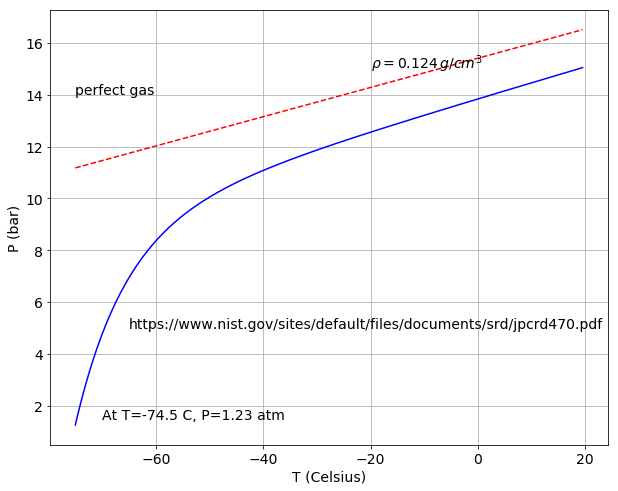

In [112]:
plt.plot(T,PF,'b')
plt.plot(T,PT,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-20, 15, r'$\rho=0.124 \, g/cm^3$')
plt.text(-75, 14, r'perfect gas')
plt.text(-65, 5, r'https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf')
plt.text(-70, 1.5, r'At T=-74.5 C, P=1.23 atm')
plt.show()

In [113]:
T = np.arange(-75.0, -72.5, 0.1)
PF = [xe.P(t, rho_1520, perfect=False) for t in T]
PT = [xe.P(t, rho_1520, perfect=True) for t in T]

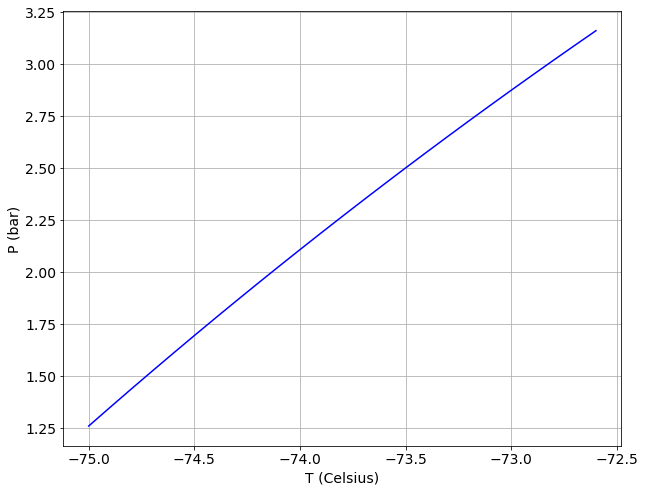

In [114]:
plt.plot(T,PF,'b')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')

In [115]:
T

array([-75. , -74.9, -74.8, -74.7, -74.6, -74.5, -74.4, -74.3, -74.2,
       -74.1, -74. , -73.9, -73.8, -73.7, -73.6, -73.5, -73.4, -73.3,
       -73.2, -73.1, -73. , -72.9, -72.8, -72.7, -72.6])

In [116]:
PF

[1.2602577653050613,
 1.3490284005358881,
 1.4368923209536359,
 1.5238599690520209,
 1.6099416617640678,
 1.6951475920344872,
 1.779487830371141,
 1.8629723263767743,
 1.9456109102603809,
 2.0274132943293695,
 2.1083890744619334,
 2.1885477315605848,
 2.267898632986808,
 2.3464510339768658,
 2.4242140790396132,
 2.5011968033358212,
 2.577408134040001,
 2.6528568916842445,
 2.7275517914850353,
 2.8015014446525628,
 2.8747143596833347,
 2.947198943636105,
 3.018963503391078,
 3.0900162468932244,
 3.1603652843791772]

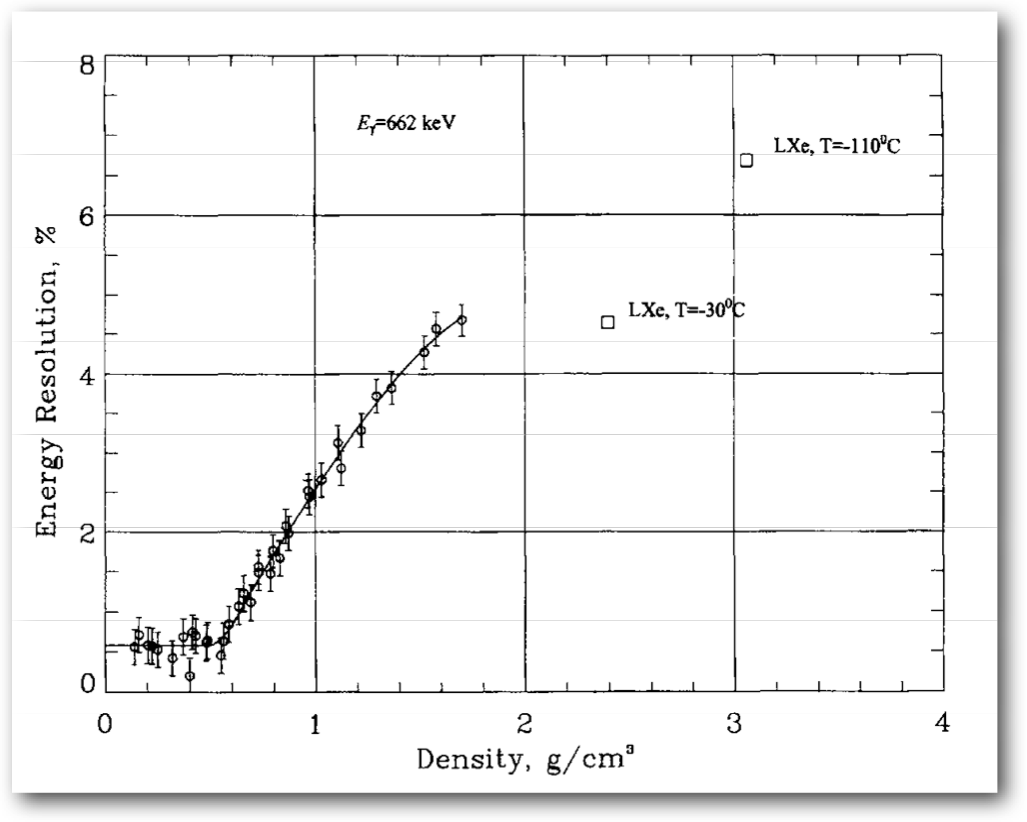

In [117]:
Image(filename='./Bolotnikov.png')

In [118]:
Tc = 198.15 #-75 C

### Second virial coefficient

In [193]:
M = 131.29 # g/mol
RM = 8.31441 # J/(K * mol) 
R = (RM / M) * J/(K * gram) 
k = 1.38064852 * 1E-23 * J/K 
N_A = 6.02214129E+23 * (1./mol)
T0 = 273.15 # 0 in K
# xenon
sigma = 0.3885 * nm
ek    = 274 * K # epsilon/k

Tc = 198.15 #-75 C
print('Tc/ek = {}'.format(Tc/ek))
Ls    = 0.06    # Lambda* 
Ls2   = Ls*Ls    # (Lambda*)^2 
Ls3   = Ls2*Ls    # (Lambda*)^3
Ls4   = Ls2*Ls2    # (Lambda*)^4
Ls6   = Ls4*Ls2    # (Lambda*)^4

uB = 1E-3 * meter3/kmol

Tc/ek = 0.7231751824817518


In [271]:

def P(t, rho, mode='P'):
    """Pressure a a function of rho and T, using B --secon virial coefficient--"""
    T = T0 + t # kelvin
    if mode == 'P':
        return rho * R * T
    elif mode =='B':
        b = B(T) / (meter3/mol) * rho /(g/m3)  # b ->g/mol
        return rho * R * T * (1  + b/M)
    else:
        return 0

In [272]:
def B(T):
    Ts = T/ek
    return (2/3) * pi * N_A * sigma**3 * Bs(Ts)

In [273]:
def Bs(T):
    return B0s(T) + Ls2 * B1s(T) + Ls4 * B2s(T) + Ls6 * B3s(T)  + Ls3 * Bps(T)

In [274]:
def B0s(T):
    if T < 1.1:
        return - sqrt(T) * exp(1/T) * (1.18623 + 1.00824 * T + 4.25571 * T**2 -
                                       18.6033 * T**3 + 20.4732 * T**4 - 8.71903 * T**5 +
                                       1.14829 * T**6)
                                       
    elif 1.1 < T < 10:
        return - sqrt(T) * exp(1/T) * (0.74685 - 1.0384 * log(T) + 0.31634 * (log(T))**2 -
                                       0.02096 * (log(T))**3 - 0.01498* (log(T))**4)
    else:
        return 0. # can be programmed if needed

In [275]:
def B1s(T):
    if T < 1.1:
        return T**(-3/2) * exp(1/T) * (0.158192 - 0.037145 * T - 0.0103125 * T**2 +
                                       0.0701852 * T**3 - 0.0328399 * T**4)
                                       
    elif 1.1 < T < 10:
        return T**(-3/2)  * exp(1/T) * (0.148 + 0.0241 * log(T) - 0.0123 * (log(T))**2 +
                                       0.0096 * (log(T))**3 - 0.0014* (log(T))**4)
    else:
        return 0. # can be programmed if needed

In [276]:
def B2s(T):
    if T < 10:
        return T**(-7/2) * exp(1/T) * (0.0152 + 0.0126 * T + 0.0001 * T**2)
    else:
        return 0. # can be programmed if needed

In [277]:
def B3s(T):
    if T < 1.1:
        return T**(-11/2) * exp(1/T) * (0.001 + 0.006 * T - 0.0197 * T**3 +
                                       0.032 * T**4 - 0.0128 * T**5)
                                       
    elif 1.1 < T < 10:
        return T**(-11/2)  * exp(1/T) * (0.0051 - 0.0112 * T - 0.0021 * T**2)
    else:
        return 0. # can be programmed if needed

In [278]:
def Bps(T):
    return 0

In [279]:
B(200)/uB

-281.61896593937513

In [280]:
P(t=0, rho=5.9*kg/m3, mode='P') / atmosphere

1.0072479504776353

In [281]:
P(t=0, rho=5.9*kg/m3, mode='B') / atmosphere

1.0003920330006368

In [295]:
rho_20 = 20*5.9*kg/m3
print(' rho = {} kg/m3 is the density at which P_perfect = {} atm P = {} atm and T = 0 C'.format(
rho_20/(kg/m3), P(t=0, rho=rho_20, mode='P') / atmosphere, P(t=0, rho=rho_20, mode='B') / atmosphere))

 rho = 118.0 kg/m3 is the density at which P_perfect = 20.144959009552707 atm P = 17.402592018753253 atm and T = 0 C


In [298]:
print(' rho = {} kg/m3, T = 0 C: P = {} atm xe.P = {} atm '.format(
rho_20/(kg/m3), P(t=0, rho=rho_20, mode='B') / atmosphere, xe.P(0, 20*5.9, perfect=False)))

 rho = 118.0 kg/m3, T = 0 C: P = 17.402592018753253 atm xe.P = 17.513373418112216 atm 


In [302]:
print(' rho = {} kg/m3, T = 0 C: P(B) = {} atm P2(B) = {} atm xe.P = {} atm '.format(
rho_20/(kg/m3), P(t=0, rho=rho_20, mode='B') / atmosphere, P2(t=0, rho=rho_20, mode='B') / atmosphere, 
                xe.P(0, 20*5.9, perfect=False)))

 rho = 118.0 kg/m3, T = 0 C: P(B) = 17.402592018753253 atm P2(B) = 17.362387854778348 atm xe.P = 17.513373418112216 atm 


In [309]:
print(' rho = {} kg/m3, T = 0 C: P2(B) = {} atm P2(C) = {} atm xe.P = {} atm '.format(
rho_20/(kg/m3), P2(t=0, rho=rho_20, mode='B') / atmosphere, P2(t=0, rho=rho_20, mode='C') / atmosphere, 
                xe.P(0, 20*5.9, perfect=False)))

 rho = 118.0 kg/m3, T = 0 C: P2(B) = 17.362387854778348 atm P2(C) = 17.45778376796492 atm xe.P = 17.513373418112216 atm 


In [132]:
rho_20 = 23.5 * 5.9 * kg/m3
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 0C'.format(
rho_20 /(kg/m3), P(0, rho_20, perfect=False) / atmosphere, P(0, rho_20, perfect=True)/ atmosphere) )

 rho = 138.65000000000003 kg/m3 is the density at which P = 19.88414640955194 atm (P_perfect = 23.670326836224433 atm) and T = 0C


In [133]:
rho_2020 = 124 * kg/m3
print(' rho = {} kg/m3 is the density at which P = {} atm (P_perfect = {} atm) and T = 20 C'.format(
rho_2020 /(kg/m3), P(20, rho_2020, perfect=False) / atmosphere, P(20, rho_2020, perfect=True)/ atmosphere) )

 rho = 124.0 kg/m3 is the density at which P = 19.88630542554124 atm (P_perfect = 22.719290232058704 atm) and T = 20 C


In [311]:
T = np.arange(-75, 25, 0.5)
PF = [xe.P(t, 124, perfect=False) for t in T]
PF2 = np.array([P(t, rho_2020, mode='B') for t in T]) / atmosphere
PT = [xe.P(t, 124, perfect=True) for t in T]
PT2 = np.array([P(t, rho_2020, mode='P') for t in T]) / atmosphere

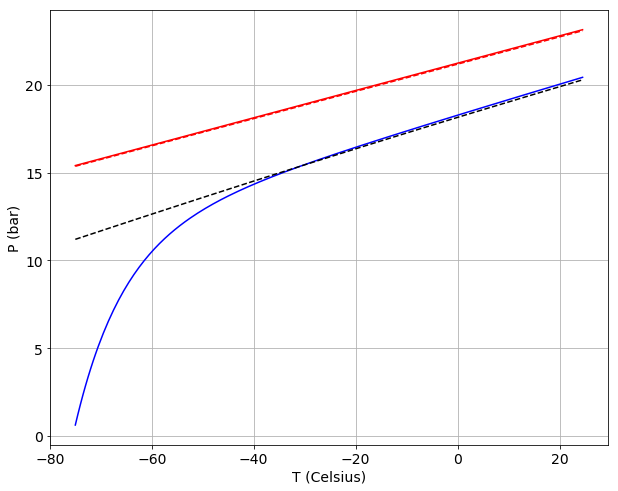

In [313]:
plt.plot(T,PF,'b')
plt.plot(T,PF2,'k--')
plt.plot(T,PT,'r')
plt.plot(T,PT2,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.show()

In [300]:
def P2(t, rho, mode='P'):
    """Pressure a a function of rho and T, using B --secon virial coefficient--"""
    T = T0 + t # kelvin
    x = 1/M        # (n/m) for Xenon
    x2 = x**2
    if mode == 'P': #perfect gas
        return rho * R * T
    elif mode =='B': # 2nd virial 
        b = B2(T) * rho /g
        return rho * R * T * (1  + b/M)
    elif mode =='C': # 2nd virial 
        b = B2(T) * rho /g
        c = C2(T) * rho**2 /g**2
        #c = C2(T) / (m**6/mol) * rho**2 /(g**2/m**6)  # b ->g/mol
        return rho * R * T * (1  + b/M + c/M**2)
    else:
        return 0

In [304]:
def B2(T):
    b0 = 5.797E-5  * (meter**3/mol)
    L = 1.6940
    ekb = 181.8     #K
    D = exp(ekb/T) - 1
    return b0 * ( 1 - (L**3 -1) * D )

def C2(T):
    b0 = 7.5731E-5 **2 * (meter**6/mol)
    l = 1.5547
    ekb = 200.88
    D = exp(ekb/T) -1 
    c1 = l**6 - 18 * l**4 + 32 * l**3 - 15
    c2 = 2 * l**6 - 36 * l**4 + 32 * l**3 + 18 * l**2 - 16
    c3 = 6 * l**6 - 18 * l**4 + 18 * l**2 - 6
    return (1/8) * b0 * ( 5 - c1 * D - c2 * D**2 - c3 * D**3)    

In [305]:
P2(t=0, rho=5.9*kg/m3, mode='P') / atmosphere

1.0072479504776353

In [306]:
P2(t=0, rho=5.9*kg/m3, mode='B') / atmosphere

1.0002915225906994

In [307]:
P2(t=0, rho=5.9*kg/m3, mode='B') / atmosphere

1.0002915225906994

In [308]:
P2(t=0, rho=5.9*kg/m3, mode='C') / atmosphere

1.000303447079848

In [268]:
P(t=20, rho=rho_2020, perfect='True') / atmosphere

22.719290232058704

In [269]:
P(t=20, rho=rho_2020, perfect='False') / atmosphere

22.719290232058704

In [265]:
P2(t=20, rho=rho_2020, mode='P') / atmosphere

22.719290232058704

In [266]:
P2(t=20, rho=rho_2020, mode='B') / atmosphere

19.836394757040683

In [255]:
B2(0+T0) /(meter**3/mol)

-0.0001536843100495061

In [256]:
B(0+T0) /(meter**3/mol)

-0.00015146379209761152

In [257]:
C2(0+T0) /(meter**6/mol)

7.74085570780144e-05

In [210]:
B(200)/uB

-281.61896593937513

In [211]:
B2(200)/uB

-273.71255692271137

In [216]:
C2(200)/uB

-8.993819627803365e+25

In [315]:
T = np.arange(-75, 25, 0.5)
PF = [xe.P(t, 124, perfect=False) for t in T]
PF2 = np.array([P(t, rho_2020, mode='B') for t in T]) / atmosphere
PF3 = np.array([P2(t, rho_2020, mode='B') for t in T]) / atmosphere
PF4 = np.array([P2(t, rho_2020, mode='C') for t in T]) / atmosphere

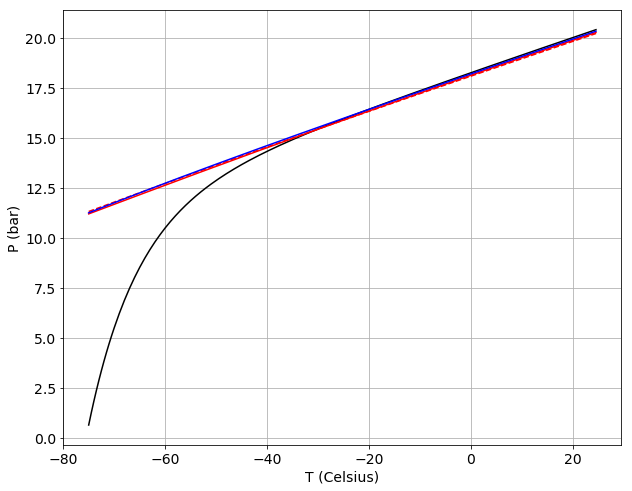

In [316]:
plt.plot(T,PF,'k')
plt.plot(T,PF2,'r')
plt.plot(T,PF3,'r--')
plt.plot(T,PF4,'b')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.show()

In [317]:
T = np.arange(-100, 25, 0.5)
PF = [xe.P(t, 124, perfect=False) for t in T]
PF2 = np.array([P(t, rho_2020, mode='B') for t in T]) / atmosphere
PF3 = np.array([P2(t, rho_2020, mode='B') for t in T]) / atmosphere
PF4 = np.array([P2(t, rho_2020, mode='C') for t in T]) / atmosphere

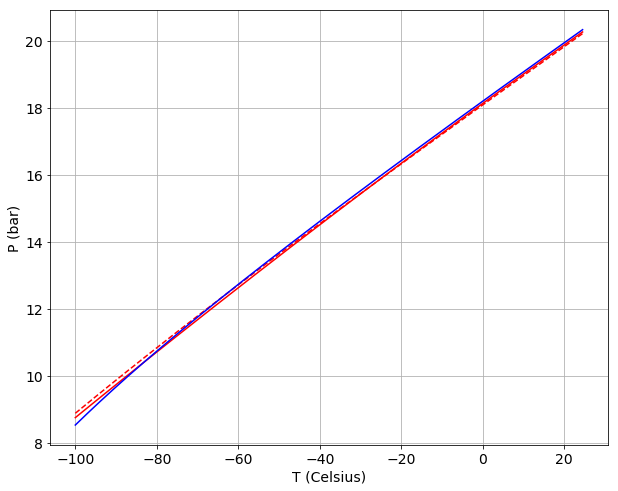

In [319]:
plt.plot(T,PF2,'r')
plt.plot(T,PF3,'r--')
plt.plot(T,PF4,'b')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.show()